In [1]:
# notebook to check on individual ignition delay detections

In [10]:
import cantera as ct
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# Load the model
cti_path = '/work/westgroup/harris.se/autoscience/autoscience/butane/sensitivity_analysis/base_rmg24/chem_annotated.cti'
cti_path = '/work/westgroup/harris.se/autoscience/autoscience/butane/sensitivity_analysis/base_rmg24/models/chem_1907.cti'
gas = ct.Solution(cti_path)

For species S(787), discontinuity in h/RT detected at Tmid = 949.21
	Value computed using low-temperature polynomial:  -21.482586140525967
	Value computed using high-temperature polynomial: -21.715196799213427



In [19]:
sp85 = gas.species()[85]

In [22]:
sp85.thermo.coeffs

array([ 9.49210000e+02,  1.16605865e+01,  4.41236559e-02, -2.07772408e-05,
        4.03962387e-09, -2.86276164e-13, -4.64108879e+04, -2.50449631e+01,
        2.98377104e-02,  9.31369094e-02, -9.82324541e-05,  5.84404205e-08,
       -1.46144596e-11, -4.39821285e+04,  3.04602026e+01])

In [21]:
dir(sp85.thermo)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_check_n_coeffs',
 'coeffs',
 'cp',
 'derived_type',
 'h',
 'max_temp',
 'min_temp',
 'n_coeffs',
 'reference_pressure',
 's']

In [3]:
# Load the experimental conditions
ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 7]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm


# list of starting conditions
# Mixture compositions taken from table 2 of
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
concentrations = []
# for phi = 1
x_diluent = 0.7649
conc_dict = {
    'O2(2)': 0.2038,
    'butane(1)': 0.03135
}

for i in range(0, len(table7)):
    x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
    x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
    x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    concentrations.append(conc_dict)

In [4]:
# Load the experimental conditions
ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 7]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm


# list of starting conditions
# Mixture compositions taken from table 2 of
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
concentrations = []
# for phi = 1
x_diluent = 0.7649
conc_dict = {
    'O2(2)': 0.2038,
    'butane(1)': 0.03135
}

for i in range(0, len(table7)):
    x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
    x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
    x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    concentrations.append(conc_dict)

In [7]:
# Take Reactor Conditions from Table 7 of supplementary info in
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
def get_delay(gas, T, P, X):
    # function to run a RCM simulation

    t_end = 1.0  # time in seconds
    gas.TPX = T, P, X

    env = ct.Reservoir(ct.Solution('air.yaml'))
    # env = ct.Reservoir(ct.Solution('air.xml'))
    reactor = ct.IdealGasReactor(gas)
    wall = ct.Wall(reactor, env, A=1.0, velocity=0)
    reactor_net = ct.ReactorNet([reactor])
    # # allegedly faster solving
    # reactor_net.derivative_settings = {"skip-third-bodies": True, "skip-falloff": True}
    # reactor_net.preconditioner = ct.AdaptivePreconditioner()

    times = [0]
    T = [reactor.T]
    P = [reactor.thermo.P]
    X = [reactor.thermo.X]  # mol fractions
    while reactor_net.time < t_end:
        reactor_net.step()

        times.append(reactor_net.time)
        T.append(reactor.T)
        P.append(reactor.thermo.P)
        X.append(reactor.thermo.X)

    slopes = np.gradient(P, times)
    i = np.argmax(slopes)
    return times[i]

In [8]:
# def run_simulation(condition_index):
#     gas = ct.Solution(cti_path)
#     X = concentrations[condition_index]
#     delay = get_delay(gas, T7[condition_index], P7[condition_index], X)
#     print(f'Completed {condition_index}:\t {delay}')
#     return delay

In [13]:
def run_simulation(gas, T, P, X):
    # function to run a RCM simulation

    t_end = 1.0  # time in seconds
    gas.TPX = T, P, X
    
    
    env = ct.Reservoir(ct.Solution('air.xml'))
    reactor = ct.IdealGasReactor(gas)
    wall = ct.Wall(reactor, env, A=1.0, velocity=0)
    reactor_net = ct.ReactorNet([reactor])
    
    
    times = [0]
    T = [reactor.T]
    P = [reactor.thermo.P]
    X = [reactor.thermo.X]  # mol fractions
    while reactor_net.time < t_end:
        reactor_net.step()

        times.append(reactor_net.time)
        T.append(reactor.T)
        P.append(reactor.thermo.P)
        X.append(reactor.thermo.X)
    
    return (times, T, P, X)

In [ ]:
# plot the simulation

# Run the Simulations

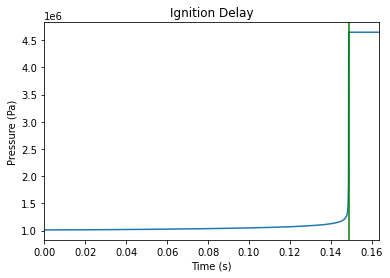

In [14]:
# for i in range(0, len(table7)):
for i in [7]:
    # aramco, keep as is
    X = concentrations[i]
    t, T, P, X = run_simulation(gas, T7[i], P7[i], X)
    save_name = f'rmg_7-{i:04}.png'
    index, delay_time = get_ignition_delay(t, T, P, X, plot=True, save=save_name)
    rmg_tau7[i] = delay_time

Text(0, 0.5, 'Pressure (Pa)')

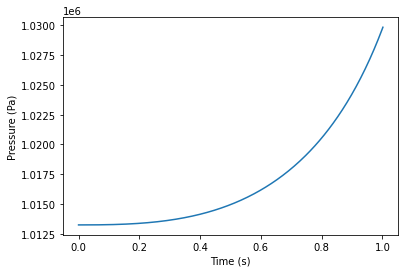

In [24]:
plt.clf()
N = 1000
plt.plot(t[:N], P[:N])
# plt.axvline(x=t[i], color='green')
# max_time = min(t[i] * 1.1, t[-1])
# plt.xlim([0, max_time])
plt.xlabel('Time (s)')
plt.ylabel('Pressure (Pa)')